# EECS16A Homework 14

##  Audio File Matching

This notebook continues the audio file matching problem. Be sure to have song.wav and clip.wav in the same directory as the notebook.

In this notebook, we will look at the problem of searching for a small audio clip inside a song.

The song "Mandelbrot Set" by Jonathan Coulton is licensed under <a href="http://creativecommons.org/licenses/by-nc/3.0/">CC BY-NC 3.0</a>

If you have trouble playing the audio file in IPython, try opening it in a different browser. I encountered problem with Safari but Chrome works for me.

### Setup

In [1]:
import imageio
import numpy as np
import wave
import matplotlib.pyplot as plt
import scipy.io.wavfile
import operator
from IPython.display import Audio

%matplotlib inline

given_file = "song.wav"
target_file = "clip.wav"
rate_given, given_signal = scipy.io.wavfile.read(given_file)
rate_target, target_signal = scipy.io.wavfile.read(target_file)
given_signal = given_signal[:2000000].astype(float)
target_signal = target_signal.astype(float)


def play_clip(start, end, signal=given_signal):
    scipy.io.wavfile.write("temp.wav", rate_given, signal[start:end].astype(np.int16))
    return Audio(url="temp.wav", autoplay=True)


def run_comparison(target_signal, given_signal, idxs=None):
    # Run everything if not called with idxs set to something
    if idxs is None:
        idxs = [i for i in range(len(given_signal) - len(target_signal))]
    return idxs, [
        vector_compare(target_signal, given_signal[i : i + len(target_signal)])
        for i in idxs
    ]


play_clip(0, len(given_signal))

# scipy.io.wavfile.write(target_file, rate_given, (-0.125*given_signal[1380000:1380000+70000]).astype(np.int16))

We will load the song into the variable `given_signal` and load the short clip into the variable `target_signal`. Your job is to finish code that will identify the short clip's location in the song. The clip we are trying to find will play after executing the following block.

In [2]:
Audio(url=target_file, autoplay=True)

### Part (e)
Your task is to define the function 'vector_compare' and run the following code. Because the song has a lot of data, you should use the provided examples from the previous parts of the problem before running the later code. Do you results here make sense given your answers to previous parts of the problem?

In [3]:
def vector_compare(desired_vec, test_vec):
    """This function compares two vectors, returning a number.
    The test vector with the highest return value is regarded as being closest to the desired vector.
    """
    # YOUR CODE HERE
    return np.dot(desired_vec.T, test_vec) / (
        np.linalg.norm(desired_vec) * np.linalg.norm(test_vec) + 1.0e-10
    )


print("Vector compare test examples:")
print(vector_compare(np.array([1, 1, 1]), np.array([1, 1, 1])))
print(vector_compare(np.array([1, 1, 1]), np.array([-1, -1, -1])))
print(vector_compare(np.array([1, 1, 1]), np.array([-1, 1, -1])))

Vector compare test examples:
0.9999999999666668
-0.9999999999666668
-0.33333333332222226


Run the following code that runs `vector_compare` on every subsequence in the song- it will probably take at least 5 minutes. How do you interpret this plot to find where the clip is in the song?

That took 3.29 minutes to run


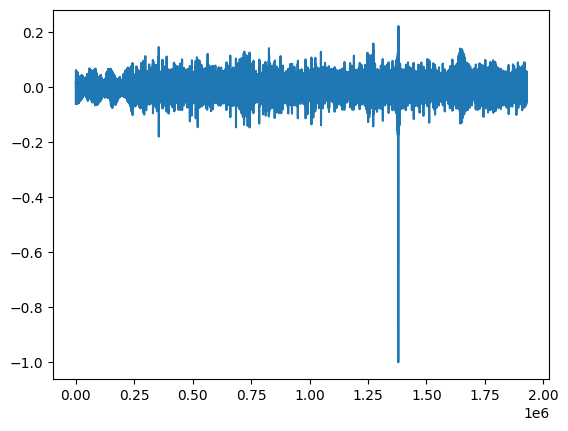

In [4]:
import time

t0 = time.time()
idxs, song_compare = run_comparison(target_signal, given_signal)
t1 = time.time()
plt.plot(idxs, song_compare)
print("That took %(time).2f minutes to run" % {"time": (t1 - t0) / 60.0})

In the space below, write code that uses `song_compare` to print the index of `given_signal` where `target_signal` begins. Then, verify that your answer is correct by playing the song at that index using the `play_clip` function.

In [5]:
# YOUR CODE HERE
# In the space below, write code that uses `song_compare` to print the index of `given_signal` where `target_signal` begins. Then, verify that your answer is correct by playing the song at that index using the `play_clip` function.

index, value = max(
    enumerate([abs(i) for i in song_compare]), key=operator.itemgetter(1)
)
print(index)
play_clip(index, index + len(target_signal))

1380000


##  Noisy Trilateration

In lecture, we learned how the GPS receiver determines its location once it knows the distance of the various signaling beacons from itself.
This method is called *trilateration*.

In this demonstration, we're going to further explore the connection between trilateration and least squares through a toy problem with four beacons and one GPS receiver.

We are given *three* possible sets of measurements for the distances of each of the beacons from the receiver:

1. First, the ideal set of measurements. $d_1 = d_2 = d_3 = d_4 = 5$.
2. Next, a set of imperfect measurements. $d_1 = 5, d_2 = 4.5, d_3 = 5, d_4 = 5.5$.
3. Finally, a set of mostly perfect measurements, but $d_1$ is a very bad measurement. We have $d_1 = 6.5$ and $d_2 = d_3 = d_4 = 5$.

First, we set up some notation for the positions of the beacons, as well as their respective distances from the receivers.

In [6]:
from utils import *

ideal_distances = [5, 5, 5, 5]
imperfect_distances = [5.5, 4.5, 5, 5]
one_bad_distances = [6.5, 5, 5, 5]

# these are the coordinates of the beacons
positions = np.array(
    [
        [0, -5],
        [-5 / 2, 5 * np.sqrt(3) / 2],
        [0, 5],
        [5 / 2, 5 * np.sqrt(3) / 2],
    ]
)

xpositions = positions[:, 0]
ypositions = positions[:, 1]

# setup to make the helper functions work
register(positions=positions)
register(xpositions=xpositions)
register(ypositions=ypositions)

### Part (d)

Now, for each of the three above cases, let's plot a circle for each beacon whose radius corresponds to the reported distance of the receiver. The intersection of the circles will tell us, intuitively, where the receiver is located! (Note that the circles do not necessarily intersect at one point for all three of the cases. Think about what this means).

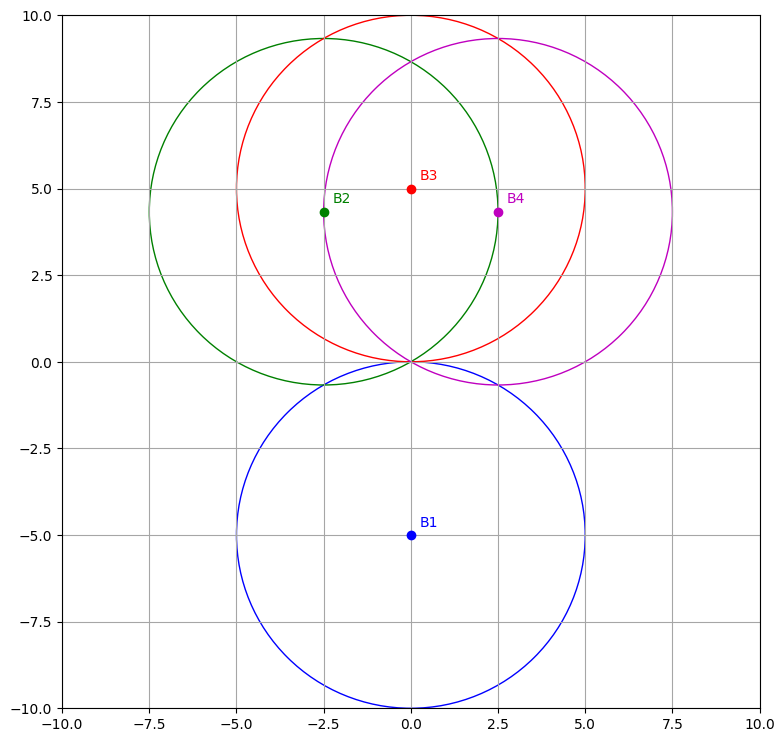

In [7]:
plot(ideal_distances)

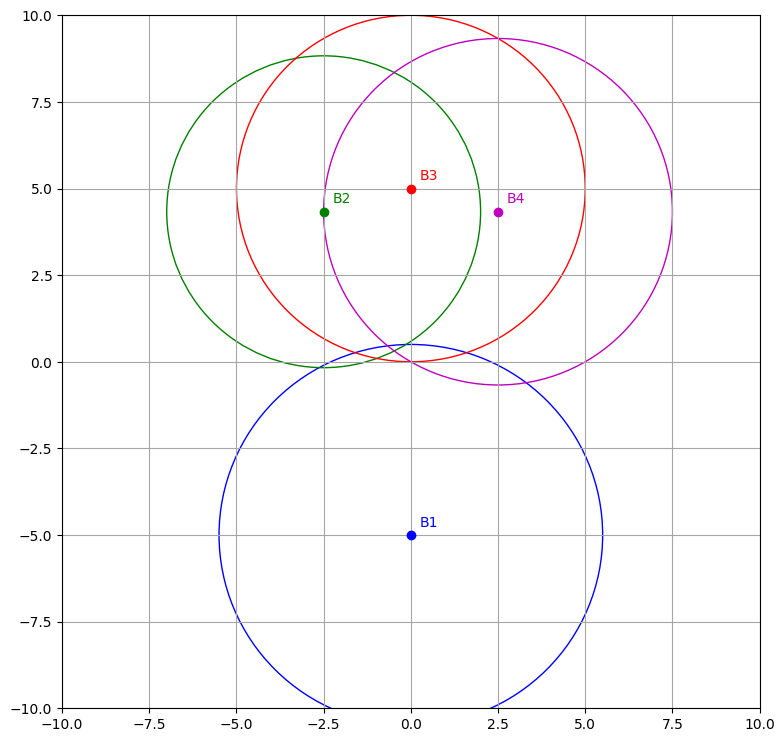

In [8]:
plot(imperfect_distances)

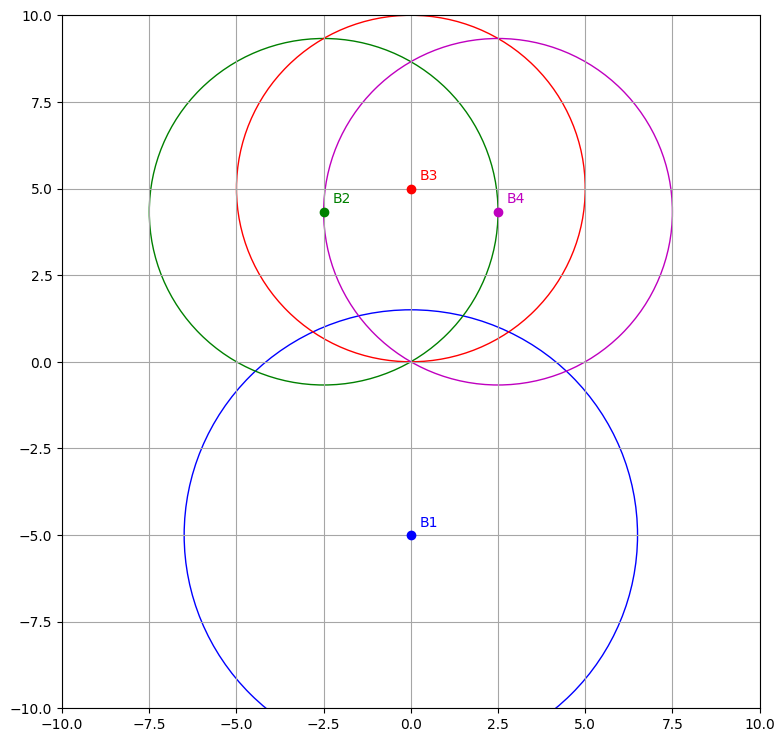

In [9]:
plot(one_bad_distances)

### Part (e)

Now, let's solve for the location of the receiver, $\begin{bmatrix}x \\ y\end{bmatrix}$, using least squares.

Recall that we made the system of equations linear by subtracting the equation for the first beacon from each of the equations for the other beacons.

This will result in the system of equations:
\begin{equation}
A\begin{bmatrix}x \\ y \end{bmatrix} = \vec{b}
\end{equation}

You will define $A$ and $\vec{b}$ in the code blocks below.

In [10]:
A = np.zeros((3, 2))

A[0][0] = 2 * (xpositions[0] - xpositions[1])
A[0][1] = 2 * (ypositions[0] - ypositions[1])
A[1][0] = 2 * (xpositions[0] - xpositions[2])
A[1][1] = 2 * (ypositions[0] - ypositions[2])
A[2][0] = 2 * (xpositions[0] - xpositions[3])
A[2][1] = 2 * (ypositions[0] - ypositions[3])
print(A)

[[  5.         -18.66025404]
 [  0.         -20.        ]
 [ -5.         -18.66025404]]


### Part (f)
Fill in the entries of `b` in the below function to correspond to the entries of $\vec{b}$ from the problem.

In [11]:
def make_b(distances):
    """
    Since `b` depends on `distances`, we implement it using a function, so we can generate
    different `b` vectors depending of which set of distances we are interested in,
    (i.e. ideal_distances, imperfect_distances, or one_bad_distances)

    Examples of how to call the function:
    make_values(ideal_distances) OR
    make_values(imperfect_distances) OR
    make_values(one_bad_distances)
    """

    b = np.zeros(3)

    b[0] = (
        xpositions[0] ** 2
        - xpositions[1] ** 2
        + ypositions[0] ** 2
        - ypositions[1] ** 2
        - distances[0] ** 2
        + distances[1] ** 2
    )
    b[1] = (
        xpositions[0] ** 2
        - xpositions[2] ** 2
        + ypositions[0] ** 2
        - ypositions[2] ** 2
        - distances[0] ** 2
        + distances[2] ** 2
    )
    b[2] = (
        xpositions[0] ** 2
        - xpositions[3] ** 2
        + ypositions[0] ** 2
        - ypositions[3] ** 2
        - distances[0] ** 2
        + distances[3] ** 2
    )

    return b


make_b(ideal_distances)

array([3.55271368e-15, 0.00000000e+00, 3.55271368e-15])

### Part (g)

Now, calculate the linear least squares estimate for the `ideal_distances` data and plot the results. We have given you code for the implementation for this part.

In [12]:
def estimate_position(distances):
    U1 = np.dot(A.T, A)
    U2 = np.dot(A.T, make_b(distances))
    least_squares_sol = np.dot(np.linalg.inv(U1), U2)
    return least_squares_sol


estimate_position(ideal_distances)

array([ 8.59260618e-33, -1.20930181e-16])

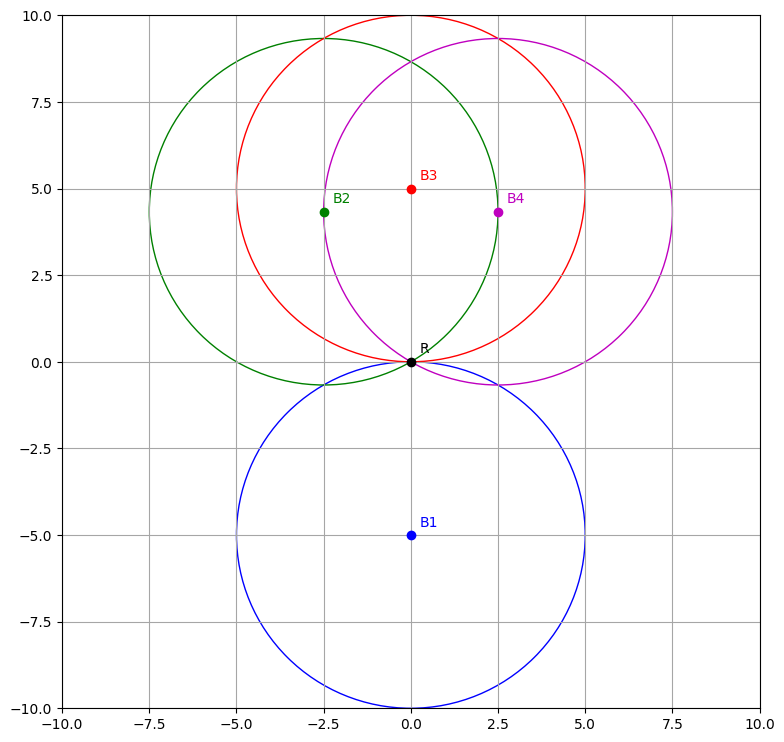

In [13]:
plot(ideal_distances)
plot_point(estimate_position(ideal_distances))

What about for the `imperfect_distances` and `one_bad_distances`? Copy and modify the above code to compute and plot the least-squares trilateration solutions for those two cases, and comment on the quality of the solution in each case.

In particular, for `one_bad_distances`, is the solution the best possible? In other words, if you were trying to identify your position from the graph by hand, would you have chosen the same point that our trilateration solution did?

array([-0.475     ,  0.35531308])

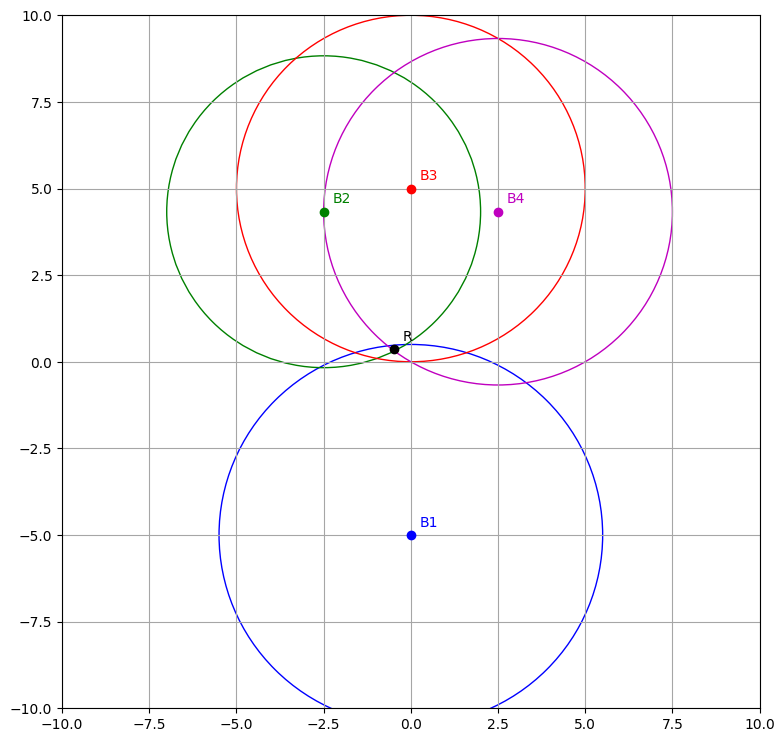

In [14]:
### imperfect_distances case

# YOUR CODE HERE
plot(imperfect_distances)
plot_point(estimate_position(imperfect_distances))
estimate_position(imperfect_distances)

array([-6.40790822e-17,  9.01832908e-01])

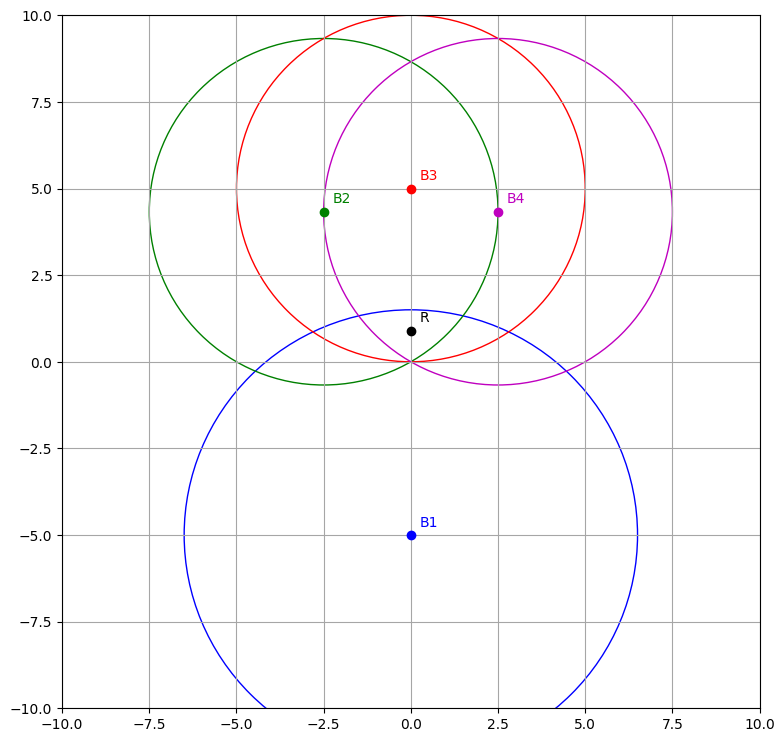

In [15]:
### one_bad_distances case

# YOUR CODE HERE
plot(one_bad_distances)
plot_point(estimate_position(one_bad_distances))
estimate_position(one_bad_distances)

##  Sparse Imaging

This example generates a sparse signal and tries to recover it using the Orthogonal Matching Pursuit algorithm.

In [16]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from IPython import display
import sys

%matplotlib inline


def randMasks(numMasks, numPixels):
    randNormalMat = np.random.normal(0, 1, (numMasks, numPixels))
    # make the columns zero mean and normalize
    for k in range(numPixels):
        # make zero mean
        randNormalMat[:, k] = randNormalMat[:, k] - np.mean(randNormalMat[:, k])
        # normalize to unit norm
        randNormalMat[:, k] = randNormalMat[:, k] / np.linalg.norm(randNormalMat[:, k])
    A = randNormalMat.copy()
    Mask = randNormalMat - np.min(randNormalMat)
    return Mask, A


def simulate():
    # read the image in grayscale
    I = np.load("helper.npy")
    sp = np.sum(I)
    numMeasurements = 6500
    numPixels = I.size
    Mask, A = randMasks(numMeasurements, numPixels)
    full_signal = I.reshape((numPixels, 1))
    measurements = np.dot(Mask, full_signal)
    measurements = measurements - np.mean(measurements)
    return measurements, A

### Part (a)

In [17]:
measurements, A = simulate()

# THE SETTINGS FOR THE IMAGE - PLEASE DO NOT CHANGE
height = 91
width = 120
sparsity = 476
numPixels = len(A[0])

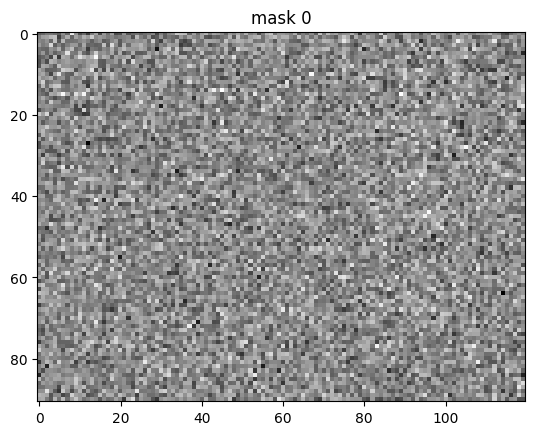

In [18]:
# CHOOSE DIFFERENT MASKS TO PLOT
chosenMaskToDisplay = 0

M0 = A[chosenMaskToDisplay].reshape((height, width))
plt.title("mask %d" % chosenMaskToDisplay)
plt.imshow(M0, cmap=plt.cm.gray, interpolation="nearest");

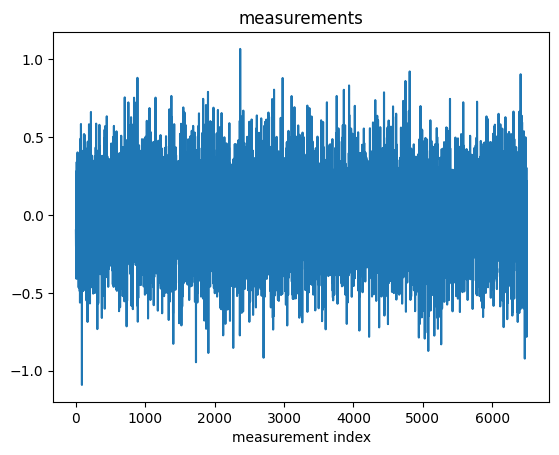

In [19]:
# measurements
plt.title("measurements")
plt.plot(measurements)
plt.xlabel("measurement index")
plt.show()

In [20]:
# OMP algorithm
# THERE ARE MISSING LINES THAT YOU NEED TO FILL
def OMP(imDims, sparsity, measurements, A):
    r = measurements.copy()
    indices = []

    # Threshold to check error. If error is below this value, stop.
    THRESHOLD = 0.1

    # For iterating to recover all signal
    i = 0

    while i < sparsity and np.linalg.norm(r) > THRESHOLD:
        # Calculate the inner products of r with columns of A
        print("%d - " % i, end="", flush=True)
        simvec = A.T.dot(r)

        # Choose pixel location with highest inner product and add to collection
        # COMPLETE THE LINE BELOW
        best_index = np.argmax(np.abs(simvec))
        indices.append(best_index)

        # Build the matrix made up of selected indices so far
        # COMPLETE THE LINE BELOW
        Atrunc = A[:, indices]

        # Find orthogonal projection of measurements to subspace
        # spanned by recovered codewords
        b = measurements
        # COMPLETE THE LINE BELOW
        xhat = np.linalg.lstsq(Atrunc, b)[0]

        # Find component orthogonal to subspace to use for next measurement
        # COMPLETE THE LINE BELOW
        r = b - Atrunc.dot(xhat)

        # This is for viewing the recovery process
        if i % 10 == 0 or i == sparsity - 1 or np.linalg.norm(r) <= THRESHOLD:
            recovered_signal = np.zeros(numPixels)
            for j, x in zip(indices, xhat):
                recovered_signal[j] = x
            Ihat = recovered_signal.reshape(imDims)
            plt.title("estimated image")
            plt.imshow(Ihat, cmap=plt.cm.gray, interpolation="nearest")
            display.clear_output(wait=True)
            display.display(plt.gcf())

        i = i + 1

    display.clear_output(wait=True)

    # Fill in the recovered signal
    recovered_signal = np.zeros(numPixels)
    for i, x in zip(indices, xhat):
        recovered_signal[i] = x

    return recovered_signal

### Part (b)

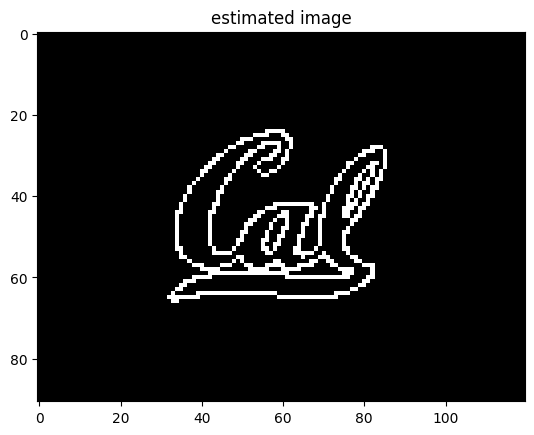

In [21]:
rec = OMP((height, width), sparsity, measurements, A)

### Part (c)


/var/folders/zl/8njxbbsx18l_dqppyzh78b9m0000gn/T/ipykernel_64056/4085815438.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fname, mode="L")


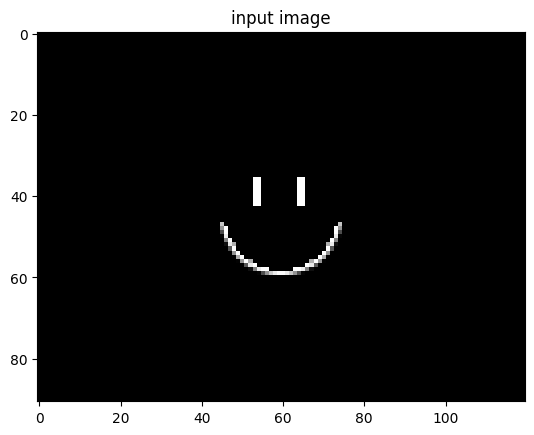

In [22]:
# the setting

# file name for the sparse image
fname = "smiley.png"
# number of measurements to be taken from the sparse image
numMeasurements = 6500
# the sparsity of the image
sparsity = 400

# read the image in black and white
I = imageio.imread(fname, mode="L")
# normalize the image to be between 0 and 1
I = I / np.max(I)

# shape of the image
imageShape = I.shape
# number of pixels in the image
numPixels = I.size

plt.title("input image")
plt.imshow(I, cmap=plt.cm.gray, interpolation="nearest");

In [23]:
# generate your image masks and the underlying measurement matrix
Mask, A = randMasks(numMeasurements, numPixels)
# vectorize your image
full_signal = I.reshape((numPixels, 1))
# get the measurements
measurements = np.dot(Mask, full_signal)
# remove the mean from your measurements
measurements = measurements - np.mean(measurements)

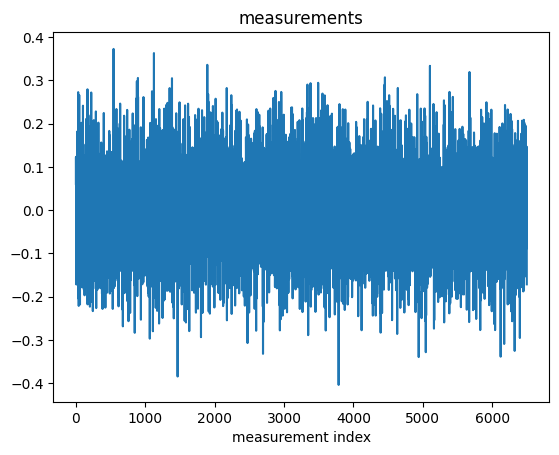

In [24]:
# measurements
plt.title("measurements")
plt.plot(measurements)
plt.xlabel("measurement index")
plt.show()

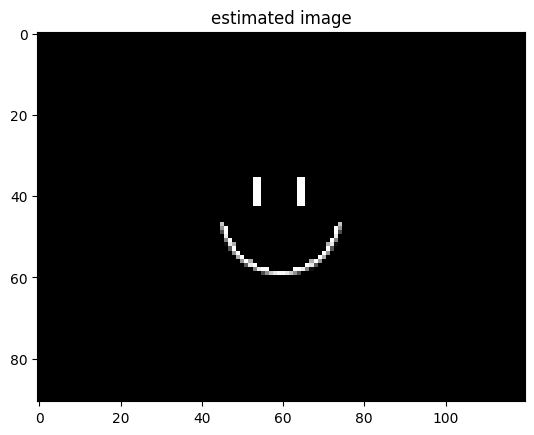

In [25]:
rec = OMP(imageShape, sparsity, measurements, A)